In [1]:
# # IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# # THEN FEEL FREE TO DELETE THIS CELL.
# # NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# # ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# # NOTEBOOK.
# import kagglehub
# masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

# print('Data source import complete.')


In [ ]:
# Data Handling
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
import gc

# Image Processing
from PIL import Image, ImageEnhance
import cv2
from tensorflow.keras.preprocessing.image import load_img

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import Xception
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import *

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the Data

### Dataset paths

In [3]:
DIR ="/kaggle/input/brain-tumor-mri-dataset"
test_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"
train_path = "/kaggle/input/brain-tumor-mri-dataset/Training"

### Hyperparameters

In [4]:
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_EPOCHS = 15
IMG_SIZE = 224
NUM_CLASSES = 4
lables = {
    "glioma" : 0,
    "meningioma" : 1,
    "notumor" : 2,
    "pituitary" : 3
}

### Reading the Dataset

In [5]:
Train = []
Train_labels = []
for label in os.listdir(train_path):
    for img in os.listdir(os.path.join(train_path, label)):
        Train.append((os.path.join(train_path, label, img), label))
        Train_labels.append(label)
Train, Train_labels = shuffle(Train, Train_labels, random_state=42)

Test = []
Test_labels = []
for label in os.listdir(test_path):
    for img in os.listdir(os.path.join(test_path, label)):
        Test.append((os.path.join(test_path, label, img), label))
        Test_labels.append(label)
Test, Test_labels = shuffle(Test, Test_labels, random_state=42)

### pie chart

Text(0.5, 1.0, 'Testing Set Distribution')

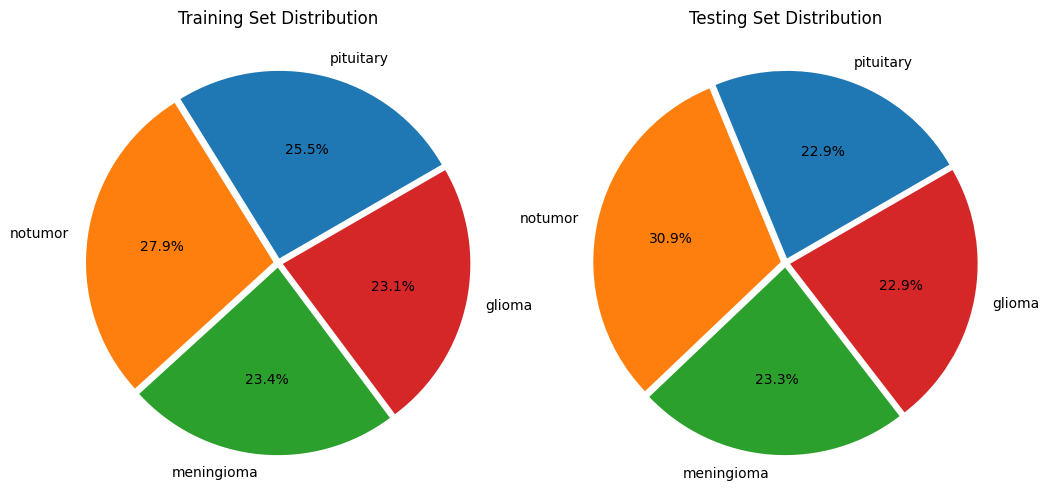

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Training Pie Chart
axs[0].pie([len([x for x in Train_labels if x=='pituitary']),
         len([x for x in Train_labels if x=='notumor']),
         len([x for x in Train_labels if x=='meningioma']),
         len([x for x in Train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
         autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);
axs[0].axis('equal')
axs[0].set_title("Training Set Distribution")

# Testing Pie Chart
axs[1].pie([len([x for x in Test_labels if x=='pituitary']),
         len([x for x in Test_labels if x=='notumor']),
         len([x for x in Test_labels if x=='meningioma']),
         len([x for x in Test_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
         autopct='%.1f%%', explode=(0.025,0.025,0.025,0.025),
        startangle=30);
axs[1].axis('equal')
axs[1].set_title("Testing Set Distribution")


### Encode labels

In [7]:
label_encoder = LabelEncoder()
Train_labels_encoded = label_encoder.fit_transform(Train_labels)
Test_labels_encoded = label_encoder.transform(Test_labels)

## 🔧 Augmentations Applied

| Augmentation    | Description                                                                                            |
| --------------- | ------------------------------------------------------------------------------------------------------ |
| `Brightness`    | Randomly increases or decreases brightness. Range: `0.8 – 1.2`                                         |
| `Contrast`      | Adjusts contrast to simulate different lighting. Range: `0.8 – 1.2`                                    |
| `Saturation`    | Enhances or reduces color richness. Range: `0.8 – 1.2` *(can still affect colorized grayscale images)* |
| `Sharpness`     | Enhances edges to highlight structures like tumors. Range: `0.8 – 1.5`                                 |
| `Normalization` | Scales pixel values back to `[0, 1]` after conversion                                                  |


In [8]:
def augment_image(image):
    """
    Apply multiple image augmentations:
    - Brightness, Contrast, Saturation, Sharpness
    """
    image = Image.fromarray(np.uint8(image * 255))
    # Brightness & contrast
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    # Saturation
    image = ImageEnhance.Color(image).enhance(random.uniform(0.8, 1.2))
    # Sharpness
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.8, 1.5))
    image = np.array(image)/255.0
    return image

In [9]:
def load_and_preprocess_image(image_path, augment=False):
    """Optimized image loading with optional augmentation"""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype(np.float32) / 255.0

    if augment:
        img = augment_image(img)
    return img

### Load training and testing images

In [10]:
X_train = np.array([
    load_and_preprocess_image(img_path, augment=True)  # augment=True for training
    for img_path, _ in tqdm(Train)
], dtype=np.float32)

y_train = np.array(Train_labels_encoded)

X_test = np.array([
    load_and_preprocess_image(img_path, augment=False)  # no augmentation for test
    for img_path, _ in tqdm(Test)
], dtype=np.float32)

y_test = np.array(Test_labels_encoded)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

100%|██████████| 1311/1311 [00:11<00:00, 111.12it/s]


Training data shape: (5712, 224, 224, 3)
Testing data shape: (1311, 224, 224, 3)


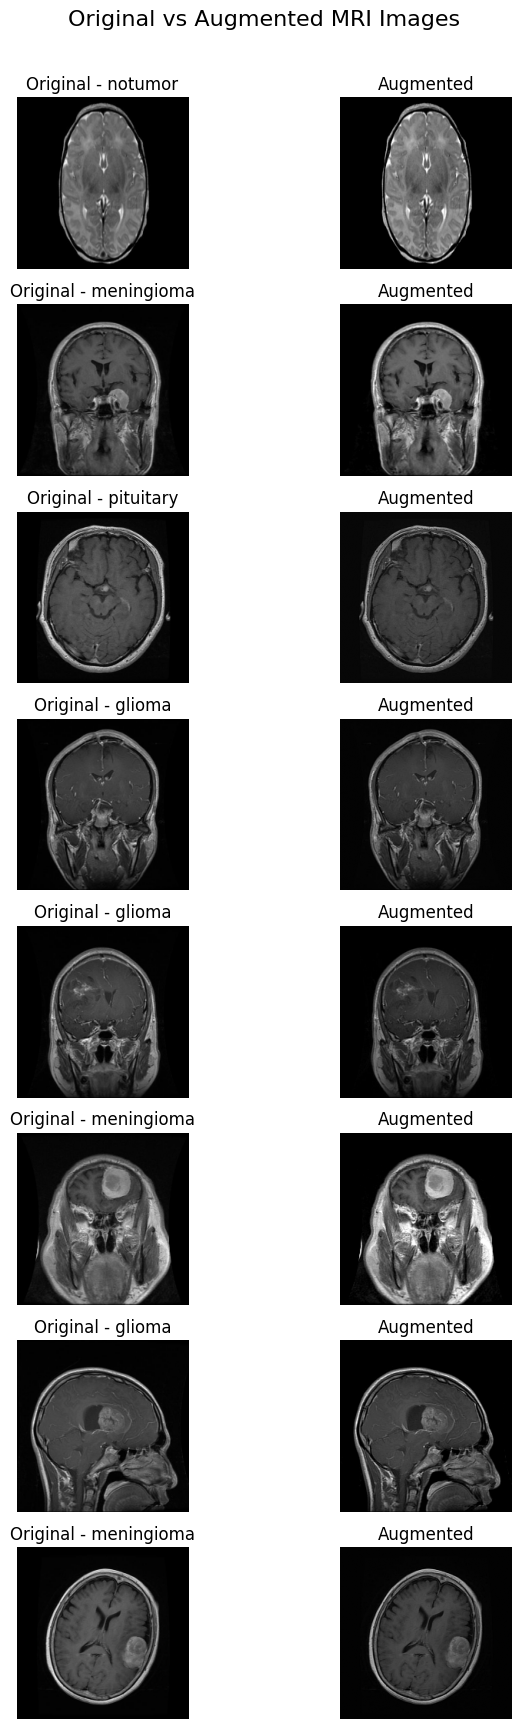

In [11]:
def visualize_augmented_samples(data_list, labels, num_samples=8):
    """
    Visualizes original vs augmented MRI samples side-by-side.

    Args:
        data_list: List of (image_path, label)
        labels: List of label names (same order as data_list)
        num_samples: Number of samples to show (will show 2*num_samples images)
    """
    assert num_samples <= len(data_list), "num_samples exceeds available data"
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 2.2))

    for i in range(num_samples):
        img_path, label = data_list[i]

        # Load augmented and original versions
        augmented_img = load_and_preprocess_image(img_path, augment=True)
        original_img = load_and_preprocess_image(img_path, augment=False)

        # Ensure pixel values are in range [0,1] for imshow
        augmented_img = np.clip(augmented_img, 0, 1)
        original_img = np.clip(original_img, 0, 1)

        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f"Original - {label}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(augmented_img)
        axes[i, 1].set_title("Augmented")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.suptitle("Original vs Augmented MRI Images", fontsize=16)
    plt.subplots_adjust(top=0.93)  # Leave space for title
    plt.show()

# Show some augmented samples
visualize_augmented_samples(Train[:8], Train_labels[:8])

# Step 2: Build VGG16 Model

## 🔧 Base Model Initialization: Xception

We use the **Xception** model as the base feature extractor with pretrained **ImageNet** weights.

In [12]:
base_model = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(IMG_SIZE, IMG_SIZE, 3)  # Xception requires minimum 71x71
)

I0000 00:00:1753157181.608681      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753157181.609398      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## 🔄 Fine-Tuning VGG16 Layers in Transfer Learning

In [13]:
# for layer in base_model.layers[:-5]:
#     layer.trainable = False

## 🧠 Model Architecture: Brain Tumor Classification using Xception + SELU Classifier

##### 📋 Explanation of Each Layer:

| Layer                                  | Description                                                                                                           |
| -------------------------------------- | --------------------------------------------------------------------------------------------------------------------- |
| `base_model` (Xception)                | Pretrained **Xception** model (top layers removed), used as a powerful feature extractor for MRI brain scan images.  |
| `GlobalAveragePooling2D()`             | Converts feature maps into a 1D vector by averaging each feature map, reducing dimensionality.                       |
| `Dense(256, activation='selu')`        | Fully connected layer with 256 neurons and **SELU** activation for self-normalizing neural networks.                |
| `AlphaDropout(0.1)`                    | Dropout layer specifically designed for use with SELU to maintain the self-normalizing property (10% dropout).       |
| `Dense(4, activation='softmax')`       | Final classification layer to output probabilities for the 4 tumor types: glioma, meningioma, no tumor, pituitary.   |

📌 **Note**:  
- **SELU + AlphaDropout** helps maintain the mean and variance of inputs throughout the network, improving convergence.
- This architecture is particularly effective when training deep networks without batch normalization.

In [14]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    # Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(256, activation='selu', kernel_initializer='lecun_normal'),
    # BatchNormalization(),
    AlphaDropout(0.1),
    Dense(4, activation='softmax', kernel_initializer='glorot_uniform')
])

## ⚙️ Optimizer and Compilation Details

In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ alpha_dropout (AlphaDropout)    │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,387,052 (81.59 MB)

 Trainable params: 21,332,524 (81.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [17]:
gc.collect()

13

## 🧠 Callbacks Configuration

We define a set of powerful callbacks to improve training efficiency and prevent overfitting:

- 🛑 **EarlyStopping**: Stops training when `val_loss` doesn't improve for 5 epochs.
- 🔽 **ReduceLROnPlateau**: Reduces the learning rate by a factor of 0.5 when `val_loss` plateaus for 3 epochs.
- 💾 **ModelCheckpoint**: Saves the model with the best `val_loss` to `'best_model.h5'`.

In [18]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

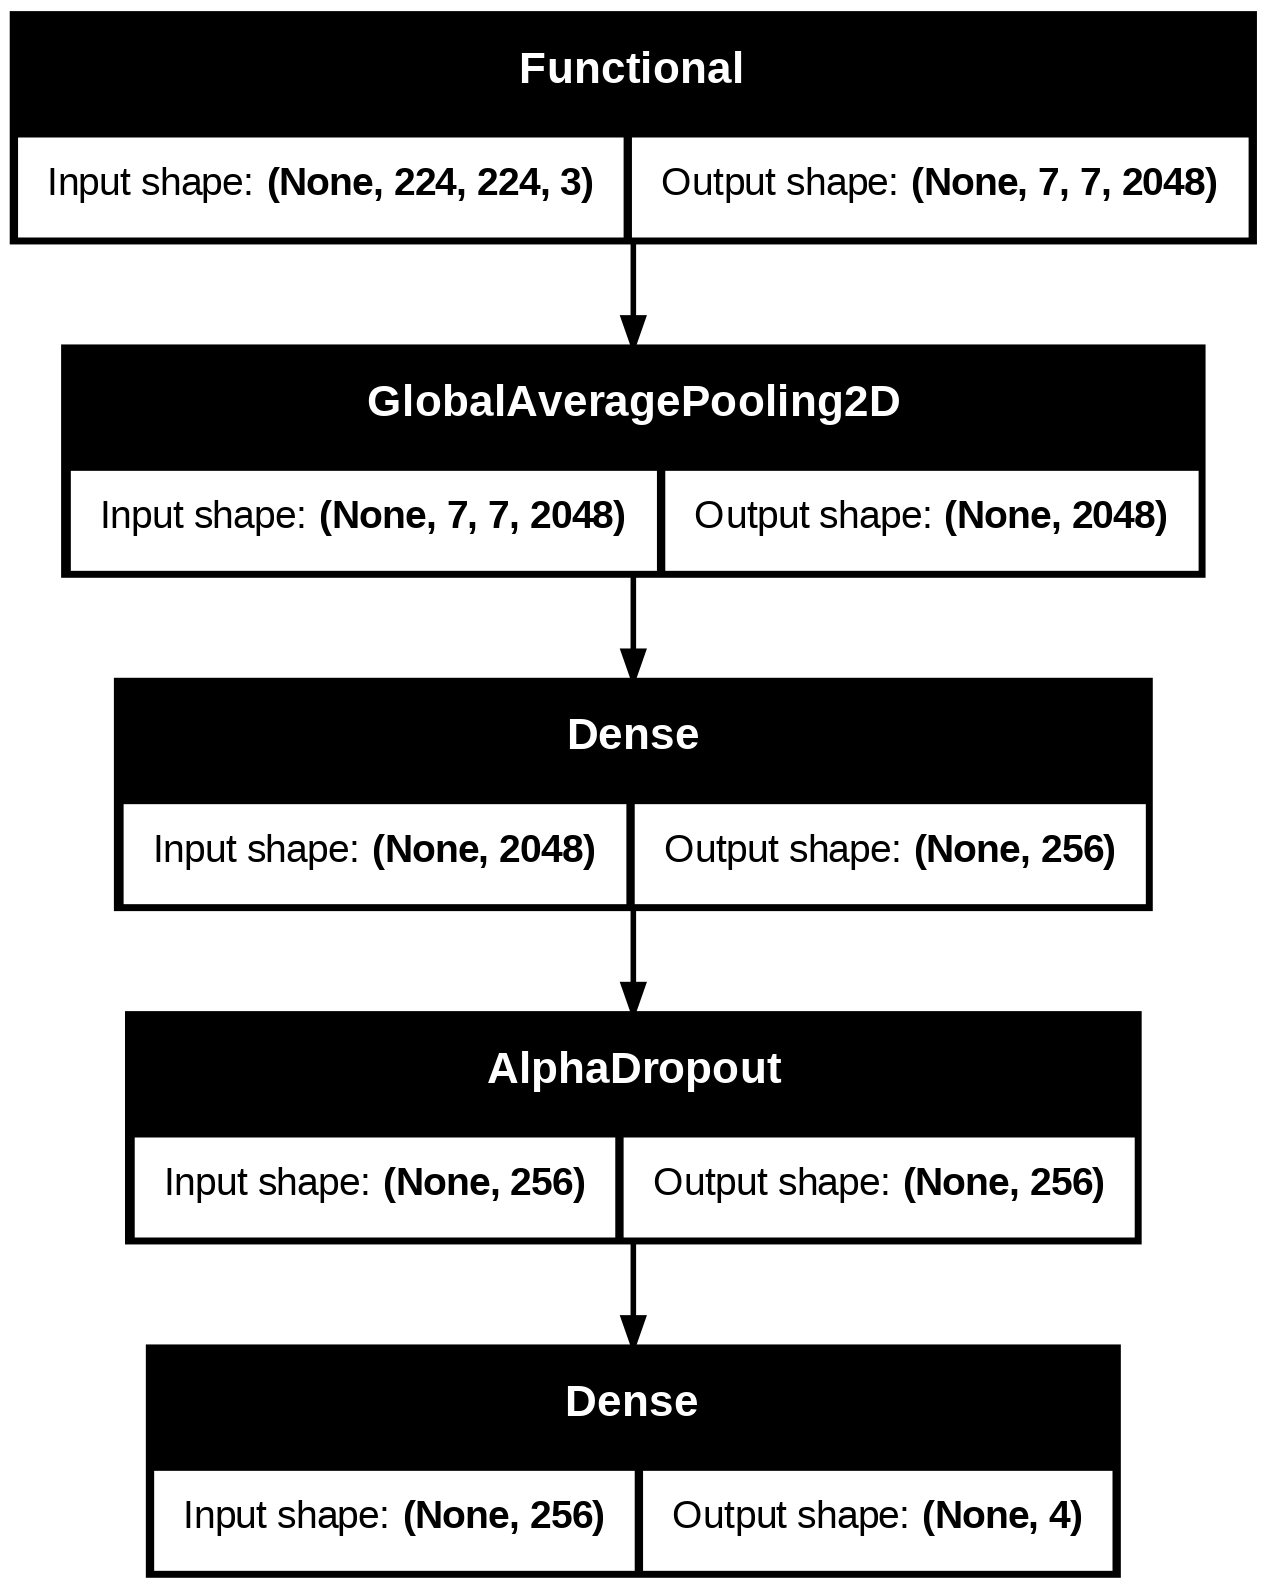

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 🚀 Model Training

We train the model using the `.fit()` function with the following settings:

- **Training data**: `X_train`, `y_train`
- **Validation data**: `X_test`, `y_test`
- **Batch size**: 32
- **Epochs**: 10
- **Callbacks**: Custom callbacks (e.g., EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)

In [21]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/10
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.8837 - loss: 0.3302

E0000 00:00:1753157378.367027     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753157378.524247     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753157379.520985     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1753157379.656674     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.8839 - loss: 0.3297
Epoch 1: val_loss improved from inf to 0.36754, saving model to best_model.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 136s 762ms/step - accuracy: 0.8841 - loss: 0.3292 - val_accuracy: 0.8658 - val_loss: 0.3675 - learning_rate: 1.0000e-04
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.9864 - loss: 0.0445
Epoch 2: val_loss improved from 0.36754 to 0.14484, saving model to best_model.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 614ms/step - accuracy: 0.9864 - loss: 0.0445 - val_accuracy: 0.9451 - val_loss: 0.1448 - learning_rate: 1.0000e-04
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.9915 - loss: 0.0235
Epoch 3: val_loss improved from 0.14484 to 0.06550, saving model to best_model.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 613ms/step - accuracy: 0.9916 - loss: 0.0235 - val_accuracy: 0.9786 - val_loss: 0.0655 - learning_rate: 1.0000e-04
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - ac

# Step 3:  Evaluation

In [22]:
y_pred_probs = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 218ms/step


## 🎯  1. Accuracy

In [23]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9931


In [26]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Find best epoch (highest val accuracy)
    best_epoch = np.argmax(val_acc) + 1
    best_val_acc = val_acc[best_epoch - 1]
    best_val_loss = val_loss[best_epoch - 1]

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
    plt.scatter(best_epoch, best_val_acc, color='green', s=100, label=f'Best Epoch ({best_epoch})')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.scatter(best_epoch, best_val_loss, color='green', s=100, label=f'Best Epoch ({best_epoch})')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.suptitle(f'Best Epoch: {best_epoch} - Val Acc: {best_val_acc:.4f}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


## 📈 2. Accuracy and Loss Curves

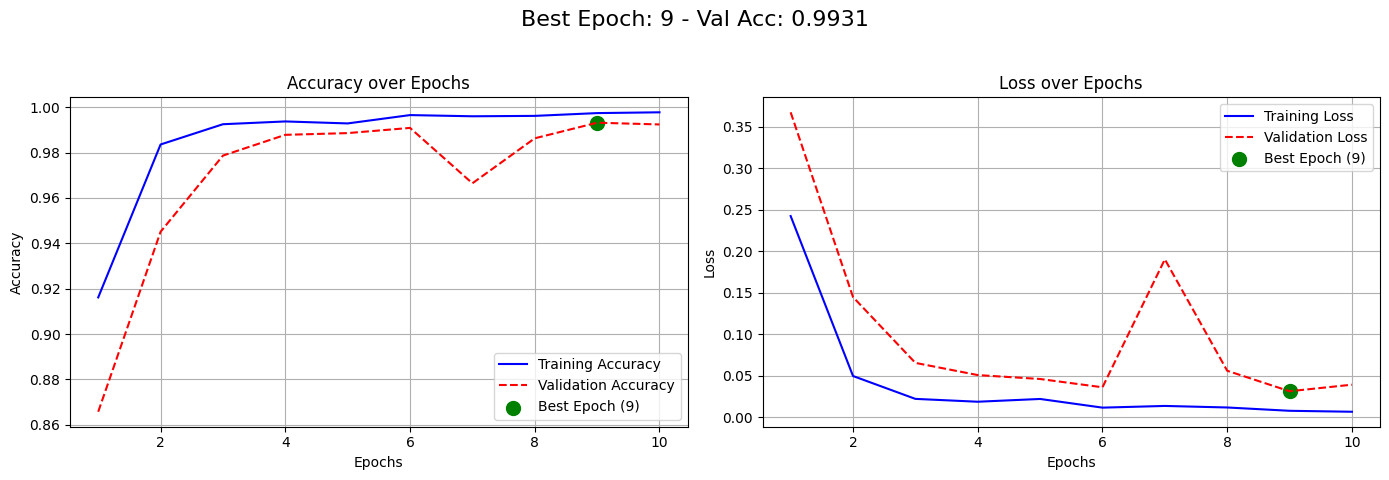

In [27]:
plot_training_history(history)

In [28]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

## 📊 3. Confusion Matrix

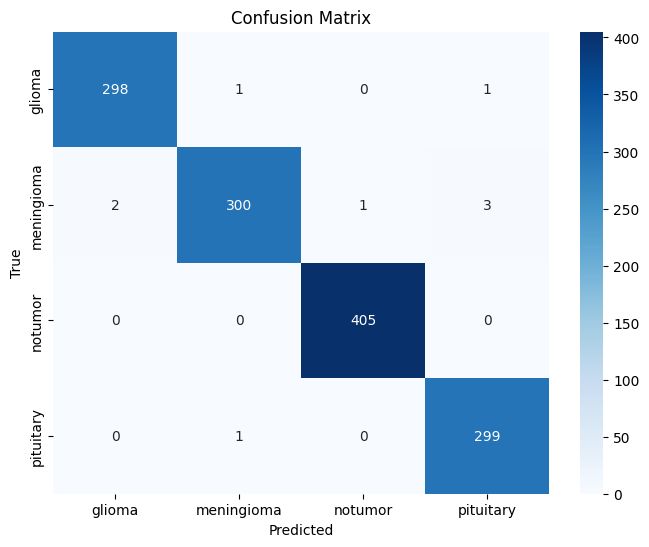

In [29]:
plot_confusion_matrix(y_test, y_pred, class_names=['glioma', 'meningioma', 'notumor', 'pituitary'])

## 🧾 4. Classification Report

In [30]:
print(classification_report(y_test, y_pred, target_names=['glioma', 'meningioma', 'notumor', 'pituitary']))

              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       300
  meningioma       0.99      0.98      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311

